In [34]:
import imageio
import random
import numpy as np
import matplotlib.pyplot as plt

from libs.util import readImg, psnr

## 1. Detect Tamper
Check Embedded Image

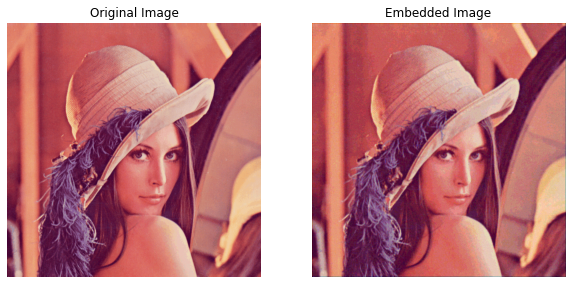

In [37]:
Origin_image = readImg("../_Image Data/Lenna/lena_color.gif")
Image = imageio.imread("./img/output/lena_embedded_eb=4.png")
H, W = Image.shape[:2]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(Origin_image)
axs[0].set_title("Original Image")
axs[0].axis('off')
axs[1].imshow(Image)
axs[1].set_title("Embedded Image")
axs[1].axis('off')
plt.show()

### 1-1. Init 

In [38]:
## User Requirerments
## Random Seed
Sd = 7

## Permutation Key
PK = 7

## Length of Embedding Codes (>=3) 
eb = 4
if eb < 3:
    raise 'eb can not be less than 3'


## block size = m*m
m = 4

## recovery code bit
n = 2

## Length of the Authentication Codes
t = eb-n
print("Length of the Authentication Codes, t={}".format(t))

working_image = np.copy(Image)

Length of the Authentication Codes, t=2


### 1-2. Authentication Code and Recovery Code Generation 

In [39]:
def generate_ac(height, width, seed, t_bitLength):
    random.seed(seed)
    ac = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(ac.shape[0]):
        for j in range(ac.shape[1]):
            for k in range(ac.shape[2]):
                ac[i, j, k] = random.randint(0, 2**t_bitLength-1)
    return ac

## AMBTC basic
def AMBTC_encode_block(block):
    Ii = np.average(block)
    Bi = np.array(block > Ii, dtype=np.bool)
    ai = np.around(np.mean((Bi*block)[Bi > 0])).astype(np.uint8)
    bi = np.around(np.mean((~Bi*block)[Bi <= 0])).astype(np.uint8)
    return ai if ai is np.nan else bi, bi, Bi

def AMBTC_decode_block(ai, bi, Bi):
    return ai*Bi + bi*(~Bi)

## AMBTC recovery codes encoding
def encodeing2nBitBlock_ambtc(array):
    encoded = np.array(array)
    block = np.zeros((m, m), dtype=np.uint8)
    block[0, 0:m] = split2nBitArray(encoded[0])
    block[1, 0:m] = split2nBitArray(encoded[1])
    block[2:m, 0:m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(m-2, m)
    return block

def encodeing2nBitBlock(block):
    encoded = np.array(AMBTC_encode_block(block))
    block = np.zeros((m, m), dtype=np.uint8)
    block[0, 0:m] = split2nBitArray(encoded[0])
    block[1, 0:m] = split2nBitArray(encoded[1])
    block[2:m, 0:m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(m-2, m)
    return block

def split2nBitArray(num, bit_size=8):
    num_array = np.zeros(bit_size//n, dtype=np.uint8)
    for i in range(bit_size//n):
        # num_array[-i]=(num % 2**n)
        num_array[bit_size//n-i-1]=(num % 2**n)
        num = num >> n
    return num_array

def flattenBinaryArray2nBitArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)//n, dtype=np.uint8)
    for i in range (len(fArr)):
        num_array[i//n] = num_array[i//n]*2 + fArr[i]
    return num_array

def encode2nBitBlocks_color_image(image):
    blocks = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(0, H, m):
        for j in range(0, W, m):
            for k in range(0, 3):
                blocks[i:i+m, j:j+m, k] = encodeing2nBitBlock(image[i:i+m, j:j+m, k])
    return blocks

## AMBTC recovery codes decoding
def convert_nBitBlock2EncodedData(block):
    ambtc_encoded_data = [0, 0, np.array((m, m), dtype=np.bool)]

    ambtc_encoded_data[0] = combine_nBitArray2Num(block[0, 0:m])
    ambtc_encoded_data[1] = combine_nBitArray2Num(block[1, 0:m])
    ambtc_encoded_data[2] = combine_nBitArray2BinaryArray(block[2:m, 0:m]).reshape(m, m)
    return ambtc_encoded_data

def combine_nBitArray2Num(arr, bit_size=8):
    num = 0
    for a in arr:
        num = num << (bit_size//len(arr))
        num+=a
    return num

def combine_nBitArray2BinaryArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)*n, dtype=np.bool)
    for i in range (len(fArr)):
        num_array[-i] = fArr[-(i//n)] % 2 == True
        fArr[-(i//n)] = fArr[-(i//n)] >> n
    return num_array

def decode2nBitBlocks_color_image(image, mask=None):
    if mask is None:
        mask = np.zeros((H, W), dtype=np.bool)
    deData = np.zeros((H, W, 3), dtype=np.uint8)
    deData_mask = np.zeros((H, W), dtype=np.bool)
    for i in range(0, H, m):
        for j in range(0, W, m):
            for k in range(0, 3):
                if mask[i:i+m, j:j+m].sum()>0:
                    deData[i:i+m, j:j+m, k] = 0
                    deData_mask[i:i+m, j:j+m] = True
                else:
                    enData = convert_nBitBlock2EncodedData(image[i:i+m, j:j+m, k])
                    deData[i:i+m, j:j+m, k] = AMBTC_decode_block(enData[0], enData[1], enData[2])
    return deData, deData_mask

### 1-3. Permutation, Repermutation, LowOrder

In [40]:
def block4x4PermutationMechanism(perm, seed):
    height, width = perm.shape[0:2]
    np.random.seed(seed)
    _perm = []
    for i in range(0, height, 4):
        for j in range(0, width, 4):
            _perm.append(perm[i:i+4, j:j+4])
    _perm = np.array([_perm]) ## , (1, height//4*width//4)
    permutation = list(np.random.permutation(height//4*width//4))
    permutedPerm = np.squeeze(_perm[:, permutation, :, :])
    newPerm = np.zeros((height, width), dtype=np.uint8)
    for i in range(0, height//4):
        for j in range(0, width//4):
            newPerm[i*4:i*4+4, j*4:j*4+4] = permutedPerm[i*width//4+j]
    return newPerm

def block4x4rePermutationMechanism(perm, seed):
    height, width = perm.shape[0:2]
    np.random.seed(seed)
    _perm = []
    for i in range(0, height, 4):
        for j in range(0, width, 4):
            _perm.append(perm[i:i+4, j:j+4])
    _perm = np.array([_perm]) ## , (1, height//4*width//4)
    permutation = list(np.random.permutation(height//4*width//4))
    rePermutation = sorted(range(len(permutation)), key=lambda k: permutation[k])
    rePermutedPerm = np.squeeze(_perm[:, rePermutation, :, :])
    newPerm = np.zeros((height, width), dtype=np.uint8)
    for i in range(0, height//4):
        for j in range(0, width//4):
            newPerm[i*4:i*4+4, j*4:j*4+4] = rePermutedPerm[i*width//4+j]
    return newPerm

In [41]:
### Get the low-order bits of the array
#### Bits is number or (start_bit, end_bit)
def getLowOrder(X, bits):
    print("DEBUG", type(bits), bits)
    if isinstance(bits, int):
        return np.array(X) & ((1 << bits) - 1)
    else:
        return (np.array(X) & ((1 << bits[1]) - 1)) >> (bits[0]-1)


### Set the low-order bits of the array
def setLowOrder(X, bits, value):
    return (np.copy(X) & ~((1 << bits) - 1)) | value

In [42]:
test_num = 12
print("binary:", np.binary_repr(test_num))
getLowOrder(test_num, (3, 4))

binary: 1100
DEBUG <class 'tuple'> (3, 4)


3

### 1-4. Tamper Detection

In [43]:
tampered_image = imageio.imread("./img/output/lena_embedded_eb=4_tp=1.png")
## 經過photoshop修改的圖片會變成(512, 512, 4)，所以把他轉回來
tampered_image = tampered_image[:, :, 0:3]

DEBUG <class 'tuple'> (3, 4)
DEBUG <class 'tuple'> (3, 4)


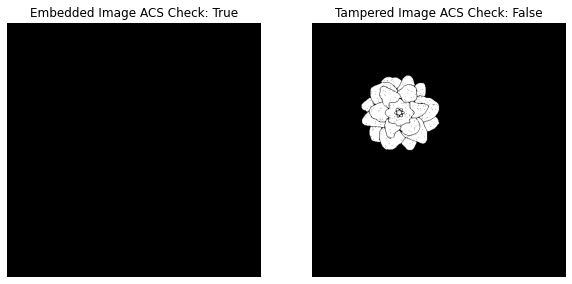

In [44]:
acs = generate_ac(H, W, Sd, t)

enbedded_acs = getLowOrder(working_image, (3, eb))
enbedded_detected_area = ~(acs == enbedded_acs)
enbedded_detected_area = (enbedded_detected_area[:, :, 0] | enbedded_detected_area[:, :, 1] | enbedded_detected_area[:, :, 2])

tampered_acs = getLowOrder(tampered_image, (3, eb))
detected_area = ~(acs == tampered_acs)
detected_area = (detected_area[:, :, 0] | detected_area[:, :, 1] | detected_area[:, :, 2])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(enbedded_detected_area, cmap='gray')
axs[0].set_title("Embedded Image ACS Check: {}".format(np.array_equal(acs, enbedded_acs)))
axs[0].axis('off')
axs[1].imshow(detected_area, cmap='gray')
axs[1].set_title("Tampered Image ACS Check: {}".format(np.array_equal(acs, tampered_acs)))
axs[1].axis('off')
plt.show()

### 1-5. Finally Detect Porcess

In [45]:
def refinement(y, x):
    ## 是否已檢測過
    complete_map[y, x] = True
    cases = np.array([
        [
            [1, 0, 0],
            [0, 0, 0],
            [0, 0, 1]
        ],
        [
            [0, 1, 0],
            [0, 0, 0],
            [0, 1, 0]
        ],
        [
            [0, 0, 1],
            [0, 0, 0],
            [1, 0, 0]
        ],
        [
            [0, 0, 0],
            [1, 0, 1],
            [0, 0, 0]
        ]
    ])
    cases_range = np.array([
        [
            [-2, 0],
            [-2, 0],
        ],
        [
            [-2, 0],
            [-1, 1]
        ],
        [
            [-2, 0],
            [0, 2]
        ],
        [
            [-1, 1],
            [0, 2]
        ],
        [
            [0, 2],
            [0, 2]
        ],
        [
            [0, 2],
            [-1, 1]
        ],
        [
            [0, 2],
            [-2, 0]
        ],
        [
            [-1, 1],
            [-2, 0]
        ]
    ])
    
    for i in range(8):
        case_patch = [
            [y+cases_range[i, 0, 0], y+cases_range[i, 0, 1]],
            [x+cases_range[i, 1, 0], x+cases_range[i, 1, 1]]
        ]
        if case_patch[0][0]<0 or case_patch[0][1]>=work_height or case_patch[1][0]<0 or case_patch[1][1]>=work_width:
            continue
        block = working_mask[case_patch[0][0]:case_patch[0][1]+1, case_patch[1][0]:case_patch[1][1]+1]*cases[i%4]
        if np.array_equal(block, cases[i%4]):
            ap_point = [y+cases_range[i, 0].sum()//2, x+cases_range[i, 1].sum()//2]
            if ap_point[0]>=0 and ap_point[0]<=work_height and ap_point[1]>=0 and ap_point[1]<=work_width:
                working_mask[ap_point[0], ap_point[1]] = True
                if complete_map[ap_point[0], ap_point[1]] == False:
                    refinement(ap_point[0], ap_point[1])
    return True

In [46]:
def getImageTrueArea(image, detected):
    _image = np.copy(image)
    if detected.ndim == 2:
        _image[:, :, 0]*=detected
        _image[:, :, 1]*=detected
        _image[:, :, 2]*=detected
    else:
        _image[:, :, 0]*=detected[:, :, 0]
        _image[:, :, 1]*=detected[:, :, 1]
        _image[:, :, 2]*=detected[:, :, 2]
    return _image

Before


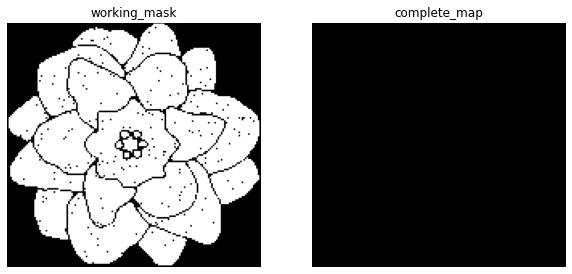

In [47]:
detected_arg = np.argwhere(detected_area == True)
patch = [
    [detected_arg[:, 0].min(), detected_arg[:, 1].min()],
    [detected_arg[:, 0].max(), detected_arg[:, 1].max()]
]
patch_height, patch_width = patch[1][0] - patch[0][0]+1, patch[1][1] - patch[0][1]+1

working_mask = np.zeros((patch_height+2, patch_width+2), dtype=np.bool)
working_mask[1:-1, 1:-1] = detected_area[patch[0][0]:patch[1][0]+1, patch[0][1]:patch[1][1]+1]
work_height, work_width = working_mask.shape[0:2]
complete_map = np.zeros(shape=(work_height, work_width), dtype=np.bool)


print("Before")
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(working_mask, cmap="gray")
axs[0].set_title("working_mask")
axs[0].axis('off')
axs[1].imshow(complete_map, cmap="gray")
axs[1].set_title("complete_map")
axs[1].axis('off')
plt.show()

[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!
[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!
[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!
[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!
[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!
After


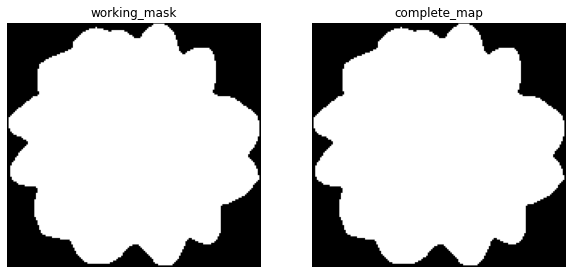

In [48]:
for p in detected_arg:
    try:
        y, x = p[0]-patch[0][0], p[1]-patch[0][1]
        refinement(y+1, x+1)
        if np.array_equal(working_mask, complete_map):
            break
    except RecursionError as e:
        print("[RecursionError]", e, "Try Again!!")
print("After")
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(working_mask, cmap="gray")
axs[0].set_title("working_mask")
axs[0].axis('off')
axs[1].imshow(complete_map, cmap="gray")
axs[1].set_title("complete_map")
axs[1].axis('off')
plt.show()

In [49]:
finally_detected_area = detected_area
finally_detected_area[patch[0][0]:patch[1][0]+1, patch[0][1]:patch[1][1]+1] = working_mask[1:-1, 1:-1]
finally_detected_size = (working_mask).sum()
finally_detected_image = getImageTrueArea(tampered_image, ~finally_detected_area)

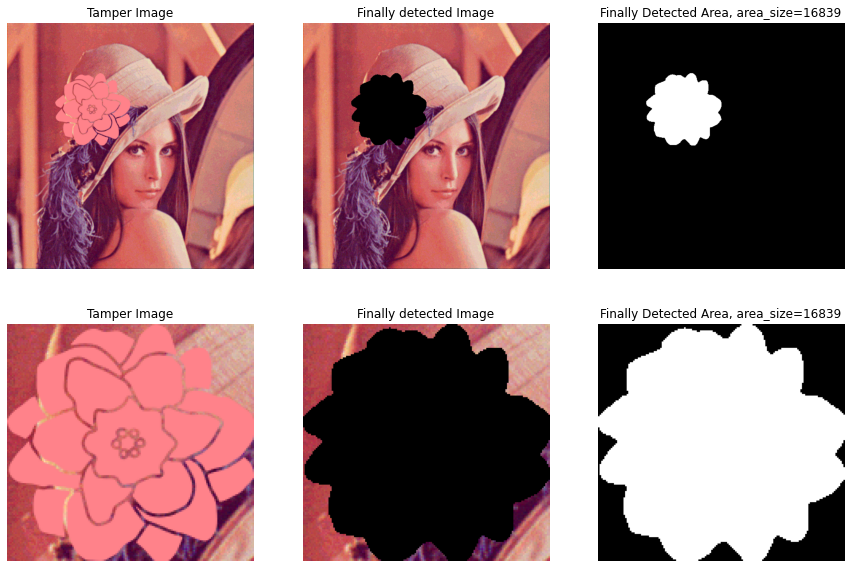

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].set_title("Tamper Image")
axs[0, 0].imshow(tampered_image)
axs[0, 0].axis('off')
axs[0, 1].set_title("Finally detected Image")
axs[0, 1].imshow(finally_detected_image)
axs[0, 1].axis('off')
axs[0, 2].set_title("Finally Detected Area, area_size={}".format(finally_detected_size))
axs[0, 2].imshow(finally_detected_area, cmap="gray")
axs[0, 2].axis('off')
axs[1, 0].set_title("Tamper Image")
axs[1, 0].imshow(tampered_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 0].axis('off')
axs[1, 1].set_title("Finally detected Image")
axs[1, 1].imshow(finally_detected_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 1].axis('off')
axs[1, 2].set_title("Finally Detected Area, area_size={}".format(finally_detected_size))
axs[1, 2].imshow(finally_detected_area[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]], cmap="gray")
axs[1, 2].axis('off')
plt.show()

## 2. Recovery Image

In [51]:
enbedded_rcs = getLowOrder(finally_detected_image, 2)
rePermuted_enbedded_rcs = np.zeros((H, W, 3), dtype=np.uint8)
rePermuted_enbedded_rcs[:, :, 0] = block4x4rePermutationMechanism(enbedded_rcs[:, :, 0], Sd)
rePermuted_enbedded_rcs[:, :, 1] = block4x4rePermutationMechanism(enbedded_rcs[:, :, 1], Sd)
rePermuted_enbedded_rcs[:, :, 2] = block4x4rePermutationMechanism(enbedded_rcs[:, :, 2], Sd)

rePermuted_enbedded_rcs

DEBUG <class 'int'> 2


array([[[3, 1, 0],
        [1, 1, 3],
        [3, 2, 2],
        ...,
        [2, 1, 0],
        [3, 2, 1],
        [0, 1, 1]],

       [[3, 1, 0],
        [1, 1, 3],
        [3, 2, 2],
        ...,
        [2, 1, 0],
        [3, 2, 1],
        [0, 1, 1]],

       [[0, 1, 0],
        [2, 1, 0],
        [0, 3, 1],
        ...,
        [2, 0, 0],
        [3, 3, 3],
        [2, 2, 2]],

       ...,

       [[0, 0, 0],
        [2, 0, 2],
        [3, 3, 3],
        ...,
        [1, 3, 0],
        [0, 1, 2],
        [0, 0, 0]],

       [[3, 0, 0],
        [3, 3, 0],
        [3, 0, 0],
        ...,
        [2, 2, 0],
        [3, 1, 3],
        [2, 2, 2]],

       [[3, 0, 0],
        [3, 3, 3],
        [0, 0, 0],
        ...,
        [2, 3, 2],
        [0, 2, 3],
        [0, 2, 3]]], dtype=uint8)

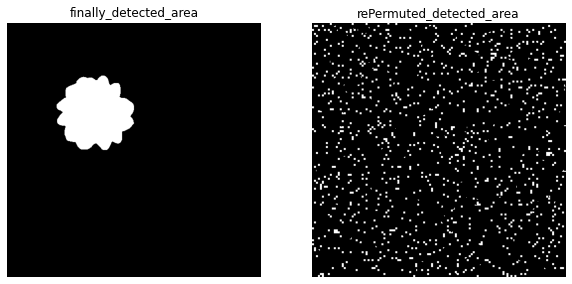

In [52]:
rePermuted_detected_area = block4x4rePermutationMechanism(finally_detected_area, Sd)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(finally_detected_area, cmap="gray")
axs[0].set_title("finally_detected_area")
axs[0].axis('off')
axs[1].imshow(rePermuted_detected_area, cmap="gray")
axs[1].set_title("rePermuted_detected_area")
axs[1].axis('off')
plt.show()

Check The AMBTC image


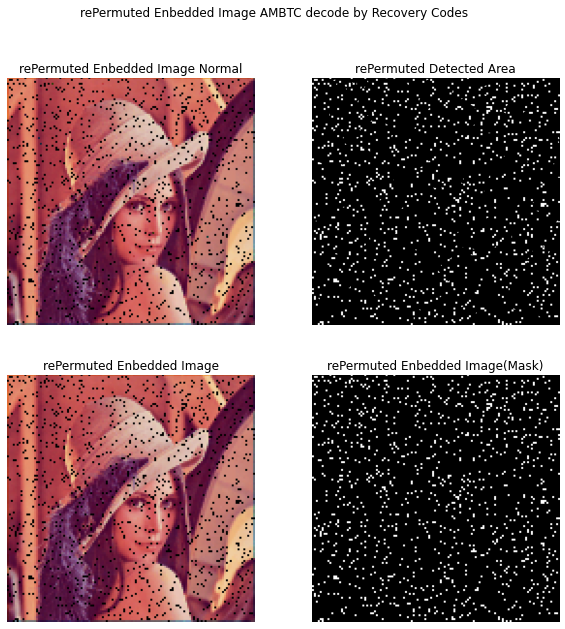

In [53]:
### 如果直接對Recovery Codes進行rePermuted，不提供Detected Area，那堤取出來的Recovery Codes就不完全是原本的Recovery Codes
rePermuted_enbedded_image_Normal, _ = decode2nBitBlocks_color_image(rePermuted_enbedded_rcs)

### 這樣提取出來的Recovery Codes在Mask以外的部分都一定是原本的Recovery Codes。
rePermuted_enbedded_image, rePermuted_enbedded_image_mask = decode2nBitBlocks_color_image(rePermuted_enbedded_rcs, rePermuted_detected_area)

print("Check The AMBTC image")
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("rePermuted Enbedded Image AMBTC decode by Recovery Codes")
axs[0, 0].imshow(rePermuted_enbedded_image_Normal)
axs[0, 0].set_title("rePermuted Enbedded Image Normal")
axs[0, 0].axis('off')
axs[0, 1].imshow(rePermuted_detected_area, cmap="gray")
axs[0, 1].set_title("rePermuted Detected Area")
axs[0, 1].axis('off')
axs[1, 0].imshow(rePermuted_enbedded_image)
axs[1, 0].set_title("rePermuted Enbedded Image")
axs[1, 0].axis('off')
axs[1, 1].imshow(rePermuted_enbedded_image_mask, cmap="gray")
axs[1, 1].set_title("rePermuted Enbedded Image(Mask)")
axs[1, 1].axis('off')
plt.show()

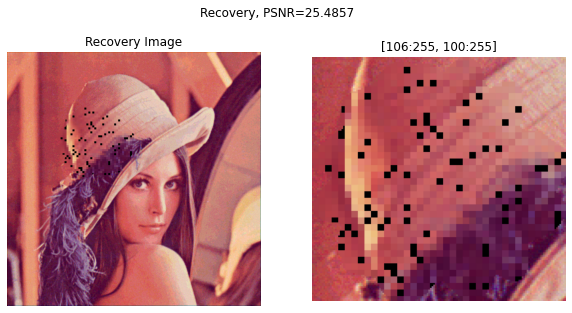

In [54]:
recovery_image = finally_detected_image + getImageTrueArea(rePermuted_enbedded_image, finally_detected_area)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Recovery, PSNR={:.4f}".format(psnr(Origin_image, recovery_image.astype('uint8'))))
axs[0].imshow(recovery_image)
axs[0].set_title("Recovery Image")
axs[0].axis('off')
axs[1].imshow(recovery_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1].set_title("[{}:{}, {}:{}]".format(patch[0][0], patch[1][0], patch[0][1], patch[1][1]))
axs[1].axis('off')
plt.show()

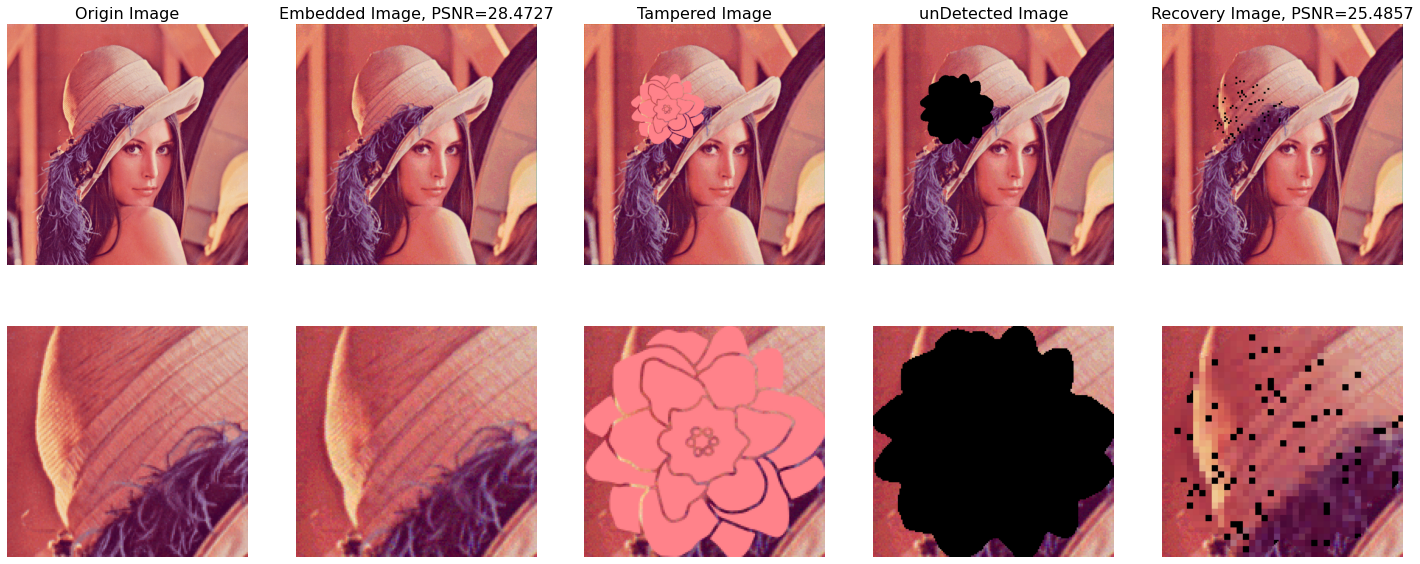

In [55]:
f_size = 16

fig, axs = plt.subplots(2, 5, figsize=(25, 10))
axs[0, 0].set_title("Origin Image", fontsize=f_size)
axs[0, 0].imshow(Origin_image)
axs[0, 0].axis('off')
axs[0, 1].set_title("Embedded Image, PSNR={:.4f}".format(psnr(Origin_image, Image.astype('uint8'))), fontsize=f_size)
axs[0, 1].imshow(Image)
axs[0, 1].axis('off')
axs[0, 2].set_title("Tampered Image", fontsize=f_size)
axs[0, 2].imshow(tampered_image)
axs[0, 2].axis('off')
axs[0, 3].set_title("unDetected Image", fontsize=f_size)
axs[0, 3].imshow(finally_detected_image)
axs[0, 3].axis('off')
axs[0, 4].set_title("Recovery Image, PSNR={:.4f}".format(psnr(Origin_image, recovery_image.astype('uint8'))), fontsize=f_size)
axs[0, 4].imshow(recovery_image)
axs[0, 4].axis('off')
axs[1, 0].imshow(Origin_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 0].axis('off')
axs[1, 1].imshow(Image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 1].axis('off')
axs[1, 2].imshow(tampered_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 2].axis('off')
axs[1, 3].imshow(finally_detected_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 3].axis('off')
axs[1, 4].imshow(recovery_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 4].axis('off')
plt.show()